## Advanced Machine Learning Models
### Goal: Achieve strong performance
### Models
 - Random Forest
 - XGBoost
 - LightGBM (primary model)
 - CatBoost
### Techniques
 - Time-series cross-validation
 - Feature importance
 - Hyperparameter tuning (Optuna)
### Output: Best ML model


# Notebook Setup & Data Preparation

 - Load feature-engineered dataset
 - Memory optimization (critical for Colab)
 - Final NaN handling (lag-safe)
### Goal:
 - target (sales_log)
 - feature list
 - Time-based train/validation split

In [1]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git

Cloning into 'Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 123 (delta 61), reused 25 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (123/123), 21.84 MiB | 40.88 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Filtering content: 100% (11/11), 315.52 MiB | 78.78 MiB/s, done.
Encountered 1 file(s) that should have been pointers, but weren't:
	data/reports/baseline_results.csv


In [2]:
# Environment Setup - Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error

import os
from pathlib import Path
import gc

In [3]:
# Set Project Root
os.chdir("/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform")
print("Current Directory: ", os.getcwd())

Current Directory:  /content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform


In [4]:
# Load Feature-Engineered Data
DATA_DIR = Path("data/features")

train = pd.read_parquet(DATA_DIR / "train_features.parquet")

In [5]:
# Memory Optimization (reduce memory usage)
def reduce_mem_usage(df, ):
  for col in df.columns:
    if df[col].dtype == "float64":
      df[col] = df[col].astype("float32")
    elif df[col].dtype == "int64":
      df[col] = df[col].astype("int32")
  return df

train = reduce_mem_usage(train)
gc.collect()

0

In [6]:
# Data Handling and Sorting
train['date'] = pd.to_datetime(train['date'])
train = train.sort_values(
    ['store_nbr', 'family', 'date']
).reset_index(drop=True)

In [7]:
# Drop NaN values in Lag/Roll Features
# identify Lag/Roll Columns
lag_cols = [col for col in train.columns if "lag" in col or "roll" in col]

# Drop NaN
initial_rows = len(train)

train = train.dropna(subset=lag_cols)

print(f"Rows dropped: {initial_rows - len(train)}")
print(f"Remaining Rows: {len(train)}")
print(f"Loose Percentage: {100 * (initial_rows - len(train)) / initial_rows:.2f}")

Rows dropped: 49896
Remaining Rows: 3004452
Loose Percentage: 1.63


In [8]:
# Define Target and Features
TARGET = 'sales_log'
y = train[TARGET]

In [9]:
# Features Selection
# Drop unnecessaary Columns
Drop_cols = ['id', 'date', 'sales', 'sales_log']

FEATURES = [col for col in train.columns if col not in Drop_cols]

X = train[FEATURES]

In [10]:
# Categorical Features
CAT_COLS = train.select_dtypes(include='category').columns.tolist()
CAT_COLS

['family',
 'city',
 'state',
 'store_type',
 'holiday_type',
 'locale',
 'locale_name',
 'description']

In [11]:
# Time Based Train / Validation Split
TRAIN_END_DATE = pd.to_datetime('2017-07-15')

train_model = train.copy()
train_mask = train_model['date'] <= TRAIN_END_DATE
valid_mask = train_model['date'] > TRAIN_END_DATE

X_train = X[train_mask]
y_train = y[train_mask]

X_valid = X[valid_mask]
y_valid = y[valid_mask]

In [12]:
# Data Split Summary
train_valid = train_model[valid_mask].reset_index(drop=True)

print("DATA SPLIT SUMMARY:\n")
print(f"Train dates: {train_model[train_mask]['date'].min().date()} to {train_model[train_mask]['date'].max().date()}")
print(f"Validation dates: {train_model[valid_mask]['date'].min().date()} to {train_model[valid_mask]['date'].max().date()}")

print(f"\nTrain Shape: {X_train.shape}")
print(f"Validation Shape: {X_valid.shape}")

DATA SPLIT SUMMARY:

Train dates: 2013-01-29 to 2017-07-15
Validation dates: 2017-07-16 to 2017-08-15

Train Shape: (2949210, 58)
Validation Shape: (55242, 58)


In [13]:
# RMSLE Evaluation Function
def rmsle(y_true, y_pred):
  y_true = np.expm1(y_true)
  y_pred = np.expm1(y_pred)
  y_pred = np.maximum(y_pred, 0)
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

## Model 1. Random Forest Model
 - Captures non-linearity
 - Strong improvement over linear models
 - Gives feature importance intuition

In [14]:
# Import Libraries
!pip install category_encoders

from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 5.1 MB/s eta 0:00:00


In [15]:
# Handling Categorical Features

te = TargetEncoder()
X_train_te = te.fit_transform(X_train, y_train)
X_valid_te = te.transform(X_valid)


In [16]:
# Define RF Model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

In [17]:
# Train RF Mdole
rf_model.fit(X_train_te, y_train)

RandomForestRegressor(max_depth=12, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=50, n_jobs=-1, random_state=42)

In [18]:
# Validation Prediction
rf_valid_pred = rf_model.predict(X_valid_te)
rf_rmsle = rmsle(y_valid, rf_valid_pred)
print(f"Random Forest RMSLE: {rf_rmsle:.4f}")

Random Forest RMSLE: 0.3985


In [19]:
# feature Importances
# Create Importance Dataframe
rf_importance = pd.DataFrame({
    'feature': X_train_te.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Sort by Importance
rf_importance = rf_importance.sort_values(by='importance', ascending=False)

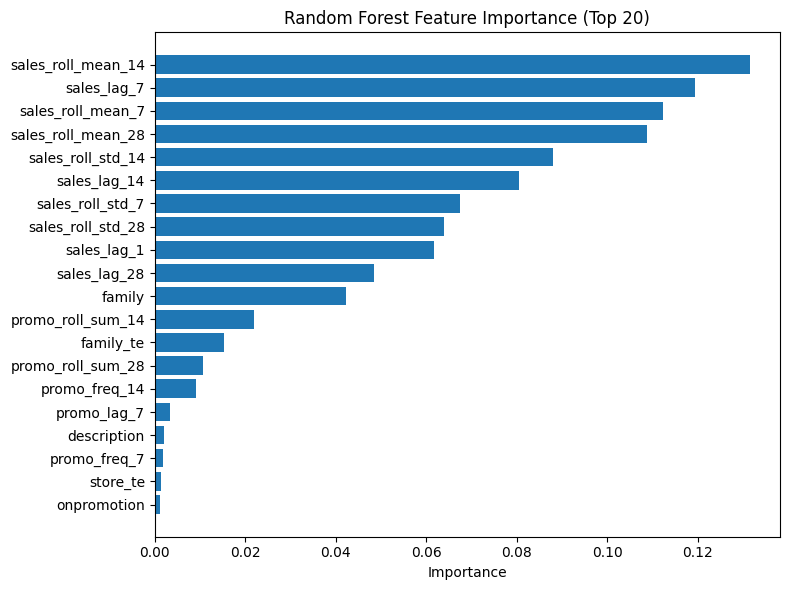

In [20]:
plt.figure(figsize=(8, 6))
plt.barh(
    rf_importance["feature"][:20][::-1],
    rf_importance["importance"][:20][::-1]
)
plt.title("Random Forest Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## Model 2. XGBoost
 -  Industry-standard GBM
 -  Excellent with lag + sparse features
 -  Strong bias–variance tradeoff
 -  Much faster & better than Random Forest

In [21]:
# Import Library
!pip install -q xgboost

import xgboost as xgb

In [22]:
# Prepare XGBoost Dataset
dtrain = xgb.DMatrix(X_train_te, label=y_train)
dvalid = xgb.DMatrix(X_valid_te, label=y_valid)

In [23]:
# Define XGB Parameters
xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",   # fast & memory efficient
    "seed": 42
}

In [24]:
evals = [(dtrain, "train"), (dvalid, "valid")]

xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)


[0]	train-rmse:2.56530	valid-rmse:2.49568
[50]	train-rmse:0.45860	valid-rmse:0.43764
[100]	train-rmse:0.39145	valid-rmse:0.38824
[150]	train-rmse:0.37987	valid-rmse:0.38444
[200]	train-rmse:0.37406	valid-rmse:0.38356
[250]	train-rmse:0.36924	valid-rmse:0.38272
[300]	train-rmse:0.36527	valid-rmse:0.38202
[350]	train-rmse:0.36219	valid-rmse:0.38126
[400]	train-rmse:0.35929	valid-rmse:0.38126
[420]	train-rmse:0.35839	valid-rmse:0.38149


In [25]:
# Validation prediction
xgb_valid_pred = xgb_model.predict(dvalid)
xgb_rmsle = rmsle(y_valid, xgb_valid_pred)
print(f"XGBoost RMSLE: {xgb_rmsle:.4f}")

XGBoost RMSLE: 0.3815


In [26]:
# Overfitting Check - Train vs Valid
xgb_train_pred = xgb_model.predict(dtrain)
train_rmsle = rmsle(y_train, xgb_train_pred)
valid_rmsle = xgb_rmsle

print(f"Train RMSLE: {train_rmsle:.4f}")
print(f"Validation RMSLE: {valid_rmsle:.4f}")

Train RMSLE: 0.3582
Validation RMSLE: 0.3815


In [27]:
# Feature Importance - Top 20
importances = xgb_model.get_score(importance_type="weight")

importance_df = pd.DataFrame({
    "feature": list(importances.keys()),
    "importance": list(importances.values())
}).sort_values(by="importance", ascending=False)

importance_df = importance_df.reset_index(drop=True)

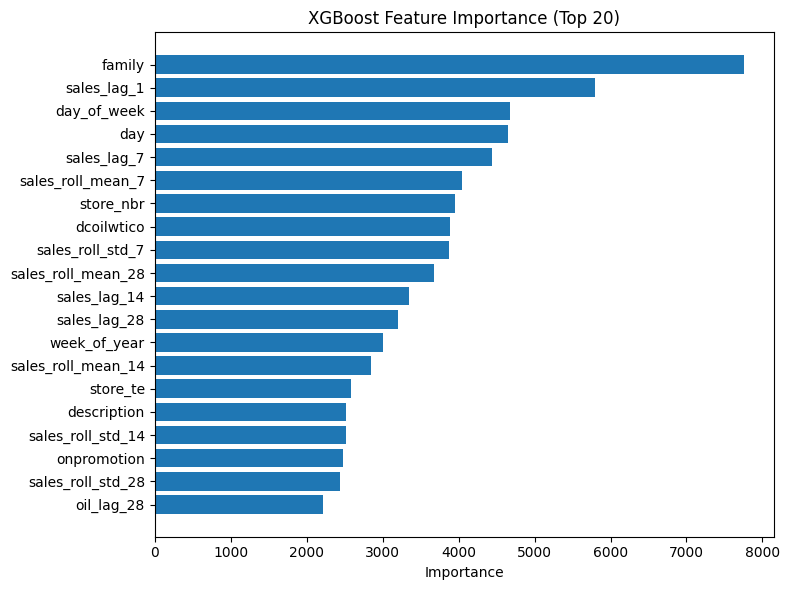

In [28]:
plt.figure(figsize=(8, 6))
plt.barh(
    importance_df["feature"][:20][::-1],
    importance_df["importance"][:20][::-1]
)
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Model 3 - LightGBM (PRIMARY MODEL)
-  Built for large tabular time-series
-  Extremely fast
-  Handles non-linearity + interactions
-  Kaggle favorite for this dataset
-  Best balance of accuracy + speed

In [29]:
# import Library
!pip install -q lightgbm

import lightgbm as lgb

In [30]:
# Prepare LightGBM Dataset
lgb_train = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=CAT_COLS,
    free_raw_data=False
)
lgb_valid = lgb.Dataset(
    X_valid,
    label=y_valid,
    reference=lgb_train,
    categorical_feature=CAT_COLS,
    free_raw_data=False
)

In [31]:
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq":5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "verbosity": -1,
    "boosting_type": "gbdt"
}

In [32]:
lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	train's rmse: 0.346272	valid's rmse: 0.377392


In [34]:
# Validation Prediction
lgb_valid_pred = lgb_model.predict(
    X_valid,
    num_iteration=lgb_model.best_iteration
)
lgb_rmsle = rmsle(y_valid, lgb_valid_pred)
print(f"LightGBM RMSLE: {lgb_rmsle:.4f}")

LightGBM RMSLE: 0.3774


In [35]:
# Feature Importance
lgb_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": lgb_model.feature_importance()
}).sort_values(by="importance", ascending=False)

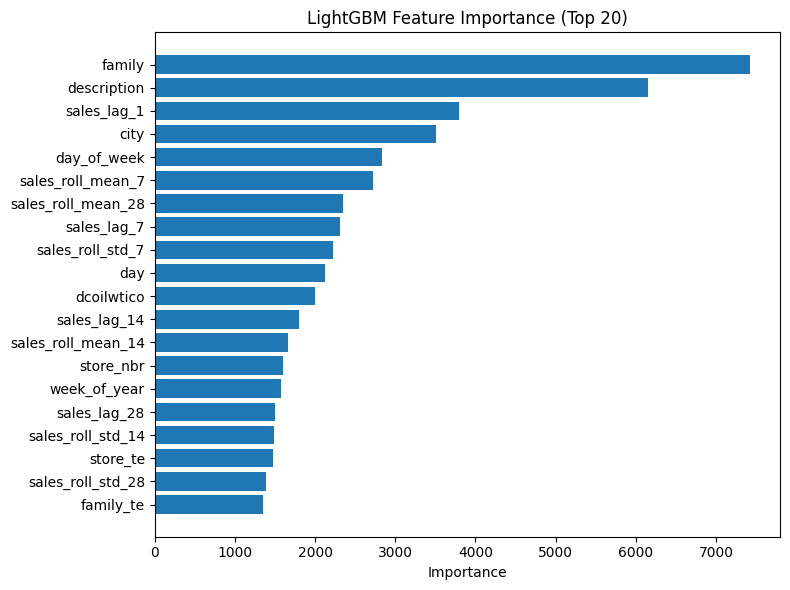

In [36]:
# Plot top 20 Features
plt.figure(figsize=(8, 6))
plt.barh(
    lgb_importance["feature"][:20][::-1],
    lgb_importance["importance"][:20][::-1]
)
plt.title("LightGBM Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

##Model 4 - CatBoost (practical view)

 - Strong with categorical features
 - Handles non-linearity well
 - Stable training, less tuning required

In [37]:
# Import Library
!pip install -q catboost

from catboost import CatBoostRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [38]:
# Define CatBoost Model
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    bagging_temperature=0.2,
    verbose=100,
    early_stopping_rounds=50
)

In [39]:
cat_model.fit(
    X_train, y_train,
    cat_features=CAT_COLS,
    eval_set=(X_valid, y_valid),
    use_best_model=True
)

0:	learn: 2.5688269	test: 2.4986272	best: 2.4986272 (0)	total: 12.5s	remaining: 3h 27m 34s
100:	learn: 0.4260240	test: 0.4039371	best: 0.4039371 (100)	total: 10m 49s	remaining: 1h 36m 17s
200:	learn: 0.4045186	test: 0.3960413	best: 0.3960413 (200)	total: 21m 20s	remaining: 1h 24m 51s
300:	learn: 0.3936766	test: 0.3920971	best: 0.3920971 (300)	total: 32m 13s	remaining: 1h 14m 49s
400:	learn: 0.3873904	test: 0.3894924	best: 0.3894924 (400)	total: 42m 53s	remaining: 1h 4m 4s
500:	learn: 0.3820464	test: 0.3872825	best: 0.3872825 (500)	total: 53m 41s	remaining: 53m 28s
600:	learn: 0.3783162	test: 0.3856260	best: 0.3856260 (600)	total: 1h 4m 14s	remaining: 42m 38s
700:	learn: 0.3749071	test: 0.3843813	best: 0.3843813 (700)	total: 1h 14m 53s	remaining: 31m 56s
800:	learn: 0.3722188	test: 0.3834235	best: 0.3834235 (800)	total: 1h 25m 29s	remaining: 21m 14s
900:	learn: 0.3700723	test: 0.3826677	best: 0.3826473 (897)	total: 1h 36m 1s	remaining: 10m 33s
999:	learn: 0.3681858	test: 0.3818389	best:

In [40]:
# Validation Prediction
cat_valid_pred = cat_model.predict(X_valid)
cat_rmsle = rmsle(y_valid, cat_valid_pred)

print(f"CatBoost RMSLE: {cat_rmsle:.4f}")

CatBoost RMSLE: 0.3818


In [41]:
# Overfitting Check
cat_train_pred = cat_model.predict(X_train)
train_rmsle = rmsle(y_train, cat_train_pred)
valid_rmsle = cat_rmsle

print(f"Train RMSLE: {train_rmsle:.4f}")
print(f"Validation RMSLE: {valid_rmsle:.4f}")

Train RMSLE: 0.3677
Validation RMSLE: 0.3818


## Model Comparision
Compare Model Based on RMSLE

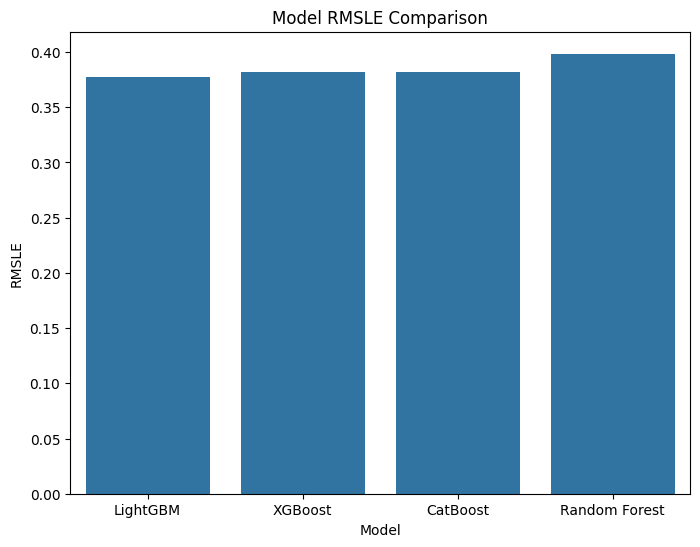

In [42]:
# Model Comparision
model_rmsle = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "LightGBM", "CatBoost"],
    "RMSLE": [rf_rmsle, xgb_rmsle, lgb_rmsle, cat_rmsle]
}).sort_values(by="RMSLE", ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="RMSLE", data=model_rmsle)
plt.title("Model RMSLE Comparison")
plt.xlabel("Model")
plt.ylabel("RMSLE")
plt.show()

## Hyperparameter Tuning with Optuna (LightGBM)

### Key Principles

 - Tune only LightGBM
 - Use time-based validation
 - Optimize RMSLE
 - Keep trials controlled

In [43]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.2 MB/s eta 0:00:00


In [44]:
def objective(trial):
  params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
    "num_leaves": trial.suggest_int("num_leaves", 31, 256),
    "max_depth": trial.suggest_int("max_depth", 5, 15),
    "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
    "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
    "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
    "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
    "verbosity": -1,
    "seed": 42
  }
  model = lgb.train(
    params=params,
    train_set=lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_valid],
    callbacks=[
      lgb.early_stopping(stopping_rounds=50),
      lgb.log_evaluation(period=0)  # period=0 disables logging
    ]
  )
  preds = model.predict(
    X_valid,
    num_iteration=model.best_iteration
  )
  return rmsle(y_valid, preds)

In [ ]:
# Run Optuna Study
study = optuna.create_study(direction="minimize")
study.optimize(
  objective,
  n_trials=50,
  show_progress_bar=True
)

[I 2025-12-30 11:24:55,109] A new study created in memory with name: no-name-20a7d242-e68c-4e47-ada4-e9b257405dab


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.372453
[I 2025-12-30 11:35:22,145] Trial 0 finished with value: 0.372447255582308 and parameters: {'learning_rate': 0.08842796844677954, 'num_leaves': 137, 'max_depth': 15, 'feature_fraction': 0.8550022707195273, 'bagging_fraction': 0.9506596068135169, 'bagging_freq': 2, 'lambda_l2': 3.9257270714125703}. Best is trial 0 with value: 0.372447255582308.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 0.378426
[I 2025-12-30 11:43:04,094] Trial 1 finished with value: 0.3784212040121713 and parameters: {'learning_rate': 0.01709582350208449, 'num_leaves': 97, 'max_depth': 13, 'feature_fraction': 0.7994578795477691, 'bagging_fraction': 0.8847752027257823, 'bagging_freq': 1, 'lambda_l2': 1.0707194974932595}. Best is trial 0 with value: 0.372447255582308.
Training until validation sc

In [ ]:
# Retrain Best Parameter and score
print('Best RMSLE', study.best_value)
print('Best Parameters:')
for key, value in study.best_params.items():
  print(f'{key}: {value}')

In [ ]:
# Retrain Fine Tuned LighGBM
best_params = study.best_params
best_params.update(
    {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "seed": 42
    }
)

final_lgb_model = lgb.train(
    params=best_params,
    train_set=lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_valid],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

In [ ]:
# Final Evaluation
final_preds = final_lgb_model.predict(
    X_valid,
    num_iteration=final_lgb_model.best_iteration
)
final_rmsle = rmsle(y_valid, final_preds)

print(f"Final Tuned LightGBM RMSLE: {final_rmsle:.4f}")

## Compare all Models

In [ ]:
# Compare all Modles
final_results = pd.DataFrame({
    "Model": [
        "Random Forest",
        "XGBoost",
        "CatBoost",
        "LightGBM (Baseline)",
        "LightGBM (Tuned)"
    ],
    "RMSLE": [
        rf_rmsle,
        xgb_rmsle,
        cat_rmsle,
        lgb_rmsle,
        final_rmsle
    ]
}).sort_values("RMSLE")

final_results


# Save Models

In [ ]:
# Save Random Forest Model
import joblib
joblib.dump(rf_model, "models/random_forest.pkl")

# Save XGBoost
xgb_model.save_model("models/xgboost.json")

# Save LightBGM
final_lgb_model.save_model("models/lightgbm.txt")

# Save CatBoost
cat_model.save_model("models/catboost.cbm", format="cbm")

In [ ]:
# Save Feature Importances
rf_importance.to_csv("rf_feature_importance.csv", index=False)
lgb_importance.to_csv("lgb_feature_importance.csv", index=False)

In [ ]:
# Final Models Report
final_results.to_csv(
    "data/reports/ml_model_comparison_reports.csv",
    index=False
)
